In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
from tqdm.auto import tqdm
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


In [3]:
project_root = os.path.abspath(
    os.path.join("C:/Users/jllgo/OneDrive/Documentos/UFMG/MSc & MSI 2/MatchSegmentation")
)
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from src.pass_networks.process_intervals import load_graphs
from src.pass_networks.custom_metrics import calculate_average_path_legth_target
from src.pass_networks.custom_metrics import calculate_wasserstein_distance
from src.pass_networks.process_match_info import get_match_info

# Get Graphs

In [5]:
PROCESSED_DATA_PATH = "../data/processed/PL-22-23"
CSV_DATA_PATH = "../data/csv"

In [6]:
players_info, teams_info, games_info = get_match_info(CSV_DATA_PATH)

In [7]:
games = os.listdir(PROCESSED_DATA_PATH)
game_ids = [game.split('.')[0] for game in games]
print(f"Games to process: {len(game_ids)}")

Games to process: 175


In [8]:
matches = []

for match_id in tqdm(game_ids, desc="Loading Graphs", total=len(game_ids)):
    match_graphs = load_graphs(match_id, PROCESSED_DATA_PATH)
    matches += match_graphs

Loading Graphs:   0%|          | 0/175 [00:00<?, ?it/s]

In [9]:
matches_df = pd.DataFrame(matches)
matches_df

,match_id,interval_id,team_id,graph
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
1,4436,1.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)"
2,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
3,4436,2.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)"
4,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
...,...,...,...,...
17225,4625,48.0,221,"(-1, 24, 30, 16, 8, 1, 7, 22, 4, 15, 23, 31)"
17226,4625,49.0,16,"(-1, 2, 8, 17, 24, 10, 22, 6, 9, 23, 31, 7)"
17227,4625,49.0,221,"(-1, 24, 30, 16, 8, 1, 7, 22, 4, 15, 23, 31)"
17228,4625,50.0,16,"(-1, 2, 8, 17, 24, 10, 22, 6, 9, 23, 31, 7)"


# Graph Stream

In [10]:
selected_metrics = {
    "Density": nx.density,
    "Average Clustering": nx.average_clustering,
    "Betweenness Centrality": nx.betweenness_centrality,
    "Closeness Centrality": nx.closeness_centrality,
    "Average Path Length": calculate_average_path_legth_target,
}

In [11]:
for metric_name, metric_func in selected_metrics.items():
    matches_df[metric_name] = matches_df["graph"].apply(lambda x: metric_func(x))

    if "Centrality" in metric_name:
        matches_df[f'Average {metric_name}'] = matches_df[metric_name].apply(lambda x: np.median(list(x.values())))


matches_df.head()

,match_id,interval_id,team_id,graph,Density,Average Clustering,Betweenness Centrality,Average Betweenness Centrality,Closeness Centrality,Average Closeness Centrality,Average Path Length
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.106061,0.000000,"{-1: 0.0, 35: 0.14545454545454545, 9: 0.0, 34:...",0.104545,"{-1: 0.0, 35: 0.3232323232323232, 9: 0.1888111...",0.197283,inf
1,4436,1.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)",0.090909,0.089286,"{-1: 0.0, 17: 0.09090909090909091, 13: 0.0, 15...",0.000000,"{-1: 0.0, 17: 0.25252525252525254, 13: 0.0, 15...",0.174825,inf
2,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.075758,0.062500,"{-1: 0.0, 35: 0.09999999999999999, 9: 0.009090...",0.004545,"{-1: 0.2727272727272727, 35: 0.204545454545454...",0.128788,1.714286
3,4436,2.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)",0.090909,0.126389,"{-1: 0.0, 17: 0.0, 13: 0.03636363636363636, 15...",0.013636,"{-1: 0.0, 17: 0.1818181818181818, 13: 0.192513...",0.128788,inf
4,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.174242,0.242645,"{-1: 0.0, 35: 0.10454545454545452, 9: 0.081818...",0.086364,"{-1: 0.0, 35: 0.43315508021390375, 9: 0.409090...",0.320158,inf


In [12]:
matches_df[['match_id','interval_id','team_id']]

,match_id,interval_id,team_id
0,4436,1.0,2
1,4436,1.0,7
2,4436,2.0,2
3,4436,2.0,7
4,4436,3.0,2
...,...,...,...
17225,4625,48.0,221
17226,4625,49.0,16
17227,4625,49.0,221
17228,4625,50.0,16


In [13]:
df_sorted = matches_df.sort_values(by=['match_id', 'team_id', 'interval_id']).reset_index(drop=True)
df_sorted.head()

,match_id,interval_id,team_id,graph,Density,Average Clustering,Betweenness Centrality,Average Betweenness Centrality,Closeness Centrality,Average Closeness Centrality,Average Path Length
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.106061,0.000000,"{-1: 0.0, 35: 0.14545454545454545, 9: 0.0, 34:...",0.104545,"{-1: 0.0, 35: 0.3232323232323232, 9: 0.1888111...",0.197283,inf
1,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.075758,0.062500,"{-1: 0.0, 35: 0.09999999999999999, 9: 0.009090...",0.004545,"{-1: 0.2727272727272727, 35: 0.204545454545454...",0.128788,1.714286
2,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.174242,0.242645,"{-1: 0.0, 35: 0.10454545454545452, 9: 0.081818...",0.086364,"{-1: 0.0, 35: 0.43315508021390375, 9: 0.409090...",0.320158,inf
3,4436,4.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.090909,0.058532,"{-1: 0.0, 35: 0.39999999999999997, 9: 0.127272...",0.145455,"{-1: 0.28321678321678323, 35: 0.34224598930481...",0.204714,2.600000
4,4436,5.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.121212,0.129299,"{-1: 0.0, 35: 0.13636363636363635, 9: 0.099999...",0.068182,"{-1: 0.27548209366391185, 35: 0.33471074380165...",0.297820,3.000000


In [14]:
# Lista para armazenar os resultados
distance_data = []

# Itera sobre os grupos de 'match_id' e 'team_id'
for (match_id, team_id), group in tqdm(df_sorted.groupby(['match_id', 'team_id']), desc="Calculating Distances", total=len(df_sorted.groupby(['match_id', 'team_id']))):
    # Ordena o grupo por 'interval_id'
    group = group.sort_values(by='interval_id').reset_index(drop=True)
    # Itera sobre os pares de grafos consecutivos
    for i in range(len(group) - 1):
        current_row = group.iloc[i]
        next_row = group.iloc[i + 1]
        # Verifica se os 'interval_id' são consecutivos
        distances = {'match_id': match_id, 'team_id': team_id, 'interval_id': i+1}
        G1 = current_row['graph']
        G2 = next_row['graph']

        # Calcula cada métrica de distância
        distances['distance'] = calculate_wasserstein_distance(G1, G2)
        distance_data.append(distances)

# Cria o novo DataFrame com as métricas de distância
df_distances = pd.DataFrame(distance_data)
df_distances

Calculating Distances:   0%|          | 0/350 [00:00<?, ?it/s]

,match_id,team_id,interval_id,distance
0,4436,2,1,0.666667
1,4436,2,2,2.166667
2,4436,2,3,1.833333
3,4436,2,4,0.666667
4,4436,2,5,0.666667
...,...,...,...,...
16875,4625,221,45,1.500000
16876,4625,221,46,0.166667
16877,4625,221,47,0.333333
16878,4625,221,48,0.500000


# Concept Drift

In [15]:
import numpy as np

In [16]:
drift_stream_df = df_distances.groupby(['match_id', 'interval_id']).agg(
    sum_distance=('distance', 'sum')
).reset_index()
drift_stream_df

,match_id,interval_id,sum_distance
0,4436,1,1.000000
1,4436,2,3.833333
2,4436,3,2.166667
3,4436,4,1.166667
4,4436,5,1.333333
...,...,...,...
8435,4625,45,3.000000
8436,4625,46,1.500000
8437,4625,47,1.000000
8438,4625,48,1.500000


In [17]:
from src.concept_drift.drift_points import detect_kswin_drift
import numpy as np

In [18]:
drift_points = []
for match_id in tqdm(drift_stream_df['match_id'].unique(), desc="Drift Analysis", total=len(drift_stream_df['match_id'].unique())):
    match_df = drift_stream_df[drift_stream_df['match_id'] == match_id].reset_index(drop=True)

    drift_avg = match_df['sum_distance'].tolist()

    kswin_drift_points = detect_kswin_drift(drift_avg, a=0.1,ws=6,ss=3,seed=42)

    drift_points.append({
        'match_id': int(match_id),
        'drift_points': kswin_drift_points,
    })
    
drift_df = pd.DataFrame(drift_points)
drift_df.head()

Drift Analysis:   0%|          | 0/175 [00:00<?, ?it/s]

,match_id,drift_points
0,4436,"[9, 24]"
1,4438,"[22, 31]"
2,4439,"[11, 22, 35, 41]"
3,4440,"[9, 15, 29, 37, 43]"
4,4441,"[22, 42]"


In [19]:
drift_df['drifts'] = drift_df['drift_points'].apply(lambda x: len(x))
drift_df.head()

,match_id,drift_points,drifts
0,4436,"[9, 24]",2
1,4438,"[22, 31]",2
2,4439,"[11, 22, 35, 41]",4
3,4440,"[9, 15, 29, 37, 43]",5
4,4441,"[22, 42]",2


In [20]:
media_drifts = drift_df['drifts'].mean()
media_drifts

np.float64(3.2114285714285713)

In [21]:
df_exploded = drift_df.explode('drift_points')
df_exploded = df_exploded.dropna().reset_index(drop=True)
df_exploded['drift_points'] = df_exploded['drift_points'].astype(int)
df_exploded.head()

,match_id,drift_points,drifts
0,4436,9,2
1,4436,24,2
2,4438,22,2
3,4438,31,2
4,4439,11,4


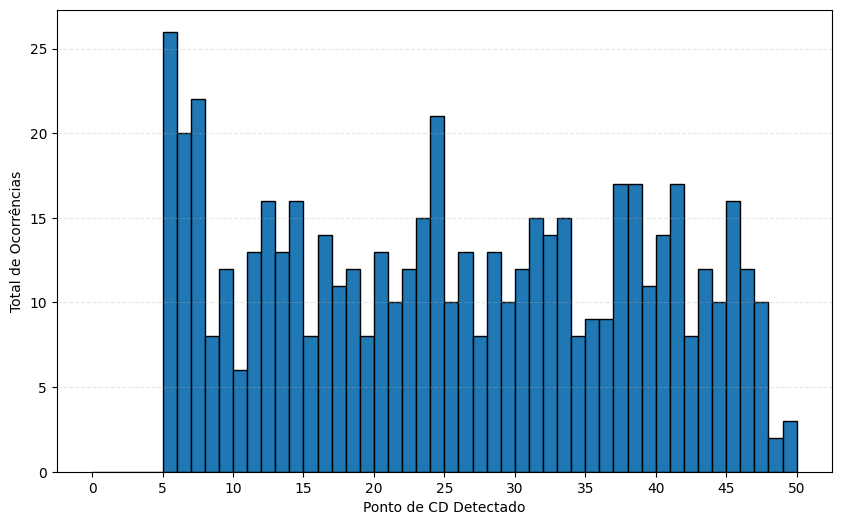

In [22]:
# Plotar o histograma
plt.figure(figsize=(10, 6))
plt.hist(df_exploded['drift_points'], bins=range(0, 51), edgecolor='black')
#plt.title('Distribuição dos Pontos de Drift Detectados')
plt.xlabel('Ponto de CD Detectado')
plt.ylabel('Total de Ocorrências')
plt.xticks(range(0, 51, 5))
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

In [23]:
drift_exploded = drift_df.explode('drift_points').reset_index(drop=True)

# Adicionar um ponto inicial 0 para facilitar a criação de intervalos
drift_exploded['start_point'] = drift_exploded.groupby('match_id')['drift_points'].shift(1).fillna(0).astype(int)
drift_exploded = drift_exploded.rename(columns={'drift_points': 'end_point'})

# Definir a fase com base nos intervalos
drift_exploded['fase'] = drift_exploded.groupby('match_id').cumcount() + 1

# Função para mapear interval_id para a fase correspondente
def get_fase(row, intervals):
    for _, interval in intervals.iterrows():
        if interval['start_point'] < row['interval_id'] <= interval['end_point']:
            return interval['fase']
    return len(intervals) + 1  # Caso o interval_id seja maior que todos os pontos de drift

# Aplicar a função para mapear as fases
df_sorted['phase'] = df_sorted.apply(lambda row: get_fase(row, drift_exploded[drift_exploded['match_id'] == row['match_id']]), axis=1)
df_sorted.head()

C:\Users\jllgo\AppData\Local\Temp\ipykernel_12704\1413752109.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  drift_exploded['start_point'] = drift_exploded.groupby('match_id')['drift_points'].shift(1).fillna(0).astype(int)


,match_id,interval_id,team_id,graph,Density,Average Clustering,Betweenness Centrality,Average Betweenness Centrality,Closeness Centrality,Average Closeness Centrality,Average Path Length,phase
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.106061,0.000000,"{-1: 0.0, 35: 0.14545454545454545, 9: 0.0, 34:...",0.104545,"{-1: 0.0, 35: 0.3232323232323232, 9: 0.1888111...",0.197283,inf,1
1,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.075758,0.062500,"{-1: 0.0, 35: 0.09999999999999999, 9: 0.009090...",0.004545,"{-1: 0.2727272727272727, 35: 0.204545454545454...",0.128788,1.714286,1
2,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.174242,0.242645,"{-1: 0.0, 35: 0.10454545454545452, 9: 0.081818...",0.086364,"{-1: 0.0, 35: 0.43315508021390375, 9: 0.409090...",0.320158,inf,1
3,4436,4.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.090909,0.058532,"{-1: 0.0, 35: 0.39999999999999997, 9: 0.127272...",0.145455,"{-1: 0.28321678321678323, 35: 0.34224598930481...",0.204714,2.600000,1
4,4436,5.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.121212,0.129299,"{-1: 0.0, 35: 0.13636363636363635, 9: 0.099999...",0.068182,"{-1: 0.27548209366391185, 35: 0.33471074380165...",0.297820,3.000000,1


In [102]:
# Normalize the 'Average Path Length' column
df_sorted['Average Path Length'] = (df_sorted['Average Path Length'] - df_sorted['Average Path Length'].min()) / (df_sorted['Average Path Length'].max() - df_sorted['Average Path Length'].min())

df_sorted.head()

,match_id,interval_id,team_id,graph,Density,Average Clustering,Betweenness Centrality,Average Betweenness Centrality,Closeness Centrality,Average Closeness Centrality,Average Path Length,phase,Moving Average Density,Moving Average Average Clustering,Moving Average Average Betweenness Centrality,Moving Average Average Path Length
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.106061,0.000000,"{-1: 0.0, 35: 0.14545454545454545, 9: 0.0, 34:...",0.104545,"{-1: 0.0, 35: 0.3232323232323232, 9: 0.1888111...",0.197283,NaN,1,0.106061,0.000000,0.104545,NaN
1,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.075758,0.062500,"{-1: 0.0, 35: 0.09999999999999999, 9: 0.009090...",0.004545,"{-1: 0.2727272727272727, 35: 0.204545454545454...",0.128788,0.285714,1,0.090909,0.031250,0.054545,1.714286
2,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.174242,0.242645,"{-1: 0.0, 35: 0.10454545454545452, 9: 0.081818...",0.086364,"{-1: 0.0, 35: 0.43315508021390375, 9: 0.409090...",0.320158,NaN,1,0.118687,0.101715,0.065152,1.714286
3,4436,4.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.090909,0.058532,"{-1: 0.0, 35: 0.39999999999999997, 9: 0.127272...",0.145455,"{-1: 0.28321678321678323, 35: 0.34224598930481...",0.204714,0.494118,1,0.111742,0.090919,0.085227,2.157143
4,4436,5.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.121212,0.129299,"{-1: 0.0, 35: 0.13636363636363635, 9: 0.099999...",0.068182,"{-1: 0.27548209366391185, 35: 0.33471074380165...",0.297820,0.588235,1,0.115530,0.123244,0.076136,2.438095


In [104]:
selected_metrics = ['Density', 'Average Clustering', 'Average Betweenness Centrality', 'Average Path Length']


for metric_name in selected_metrics:
    df_sorted[f'Moving Average {metric_name}'] = df_sorted[metric_name].rolling(window=4, min_periods=1).mean()

df_sorted.head()

,match_id,interval_id,team_id,graph,Density,Average Clustering,Betweenness Centrality,Average Betweenness Centrality,Closeness Centrality,Average Closeness Centrality,Average Path Length,phase,Moving Average Density,Moving Average Average Clustering,Moving Average Average Betweenness Centrality,Moving Average Average Path Length
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.106061,0.000000,"{-1: 0.0, 35: 0.14545454545454545, 9: 0.0, 34:...",0.104545,"{-1: 0.0, 35: 0.3232323232323232, 9: 0.1888111...",0.197283,NaN,1,0.106061,0.000000,0.104545,NaN
1,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.075758,0.062500,"{-1: 0.0, 35: 0.09999999999999999, 9: 0.009090...",0.004545,"{-1: 0.2727272727272727, 35: 0.204545454545454...",0.128788,0.285714,1,0.090909,0.031250,0.054545,0.285714
2,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.174242,0.242645,"{-1: 0.0, 35: 0.10454545454545452, 9: 0.081818...",0.086364,"{-1: 0.0, 35: 0.43315508021390375, 9: 0.409090...",0.320158,NaN,1,0.118687,0.101715,0.065152,0.285714
3,4436,4.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.090909,0.058532,"{-1: 0.0, 35: 0.39999999999999997, 9: 0.127272...",0.145455,"{-1: 0.28321678321678323, 35: 0.34224598930481...",0.204714,0.494118,1,0.111742,0.090919,0.085227,0.389916
4,4436,5.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.121212,0.129299,"{-1: 0.0, 35: 0.13636363636363635, 9: 0.099999...",0.068182,"{-1: 0.27548209366391185, 35: 0.33471074380165...",0.297820,0.588235,1,0.115530,0.123244,0.076136,0.456022


# Characterize Phases

In [93]:
df_sorted.replace([np.inf, -np.inf], np.nan, inplace=True)

In [94]:
df_grouped = df_sorted.groupby(['match_id', 'team_id', 'phase']).agg({
    'Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()
df_grouped.rename(columns={'Density': 'Average Density'}, inplace=True)
df_grouped.head()

,match_id,team_id,phase,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
0,4436,2,1,0.105219,0.146248,0.048906,0.182668,2.438095
1,4436,2,2,0.054040,0.065347,0.004697,0.087437,1.000000
2,4436,2,3,0.032513,0.023035,0.003504,0.034207,1.000000
3,4436,7,1,0.045455,0.033995,0.002020,0.053937,NaN
4,4436,7,2,0.064141,0.053361,0.015505,0.094555,1.843750


# Viz Drift Detection

In [133]:
def plot_match_segmentation(df, drift_points, metrics, team_names=None, team_colors=None):
    """
    Plota a segmentação de uma partida com base em uma métrica fornecida, destacando os pontos de drift.

    Parâmetros:
    - match_id: ID da partida.
    - diff_series: Série de diferenças (por exemplo, soma das distâncias).
    - drift_points: Pontos de drift identificados.
    - metric_series1: Série da métrica para o Time 1.
    - metric_series2: Série da métrica para o Time 2.
    - metric_name: Nome da métrica a ser plotada.
    - team_names: Lista opcional com os nomes dos times [nome_time1, nome_time2].
    - team_colors: Lista opcional com as cores para os times [cor_time1, cor_time2].
    """

    max_value = None
    for team_id in df['team_id'].unique():
        team_df = df[df['team_id'] == team_id].reset_index(drop=True)

        print(f"Team ID: {team_id}")

        # Plotar o gráfico
        plt.figure(figsize=(20, 5))

        for metric_name in metrics:

            metric_name = f'Moving Average {metric_name}'

            metric_series1 = team_df[metric_name].reset_index(drop=True)

            if 'Path' in metric_name:
                max_value = metric_series1.max() if max_value is None else max(max_value, metric_series1.max())

            plt.plot(metric_series1, label=metric_name)

        # Adicionar linhas verticais nos pontos de drift
        for point in drift_points:
            plt.axvline(x=point, color='red', linestyle='--')


        if max_value is None:
            max_value = 0.2

        # Configurações adicionais do gráfico
        plt.xticks(np.arange(0, len(metric_series1), step=3))
        #plt.title(f"Segmentação da Partida {match_id} - {metric_name}")
        plt.legend()
        plt.ylim(0, max_value+0.1)
        plt.xlabel('Intervalo de Tempo')
        plt.ylabel(f'Valor de {metric_name}')
        plt.grid(False)
        plt.show()

Match ID: 4578
Team ID: 8


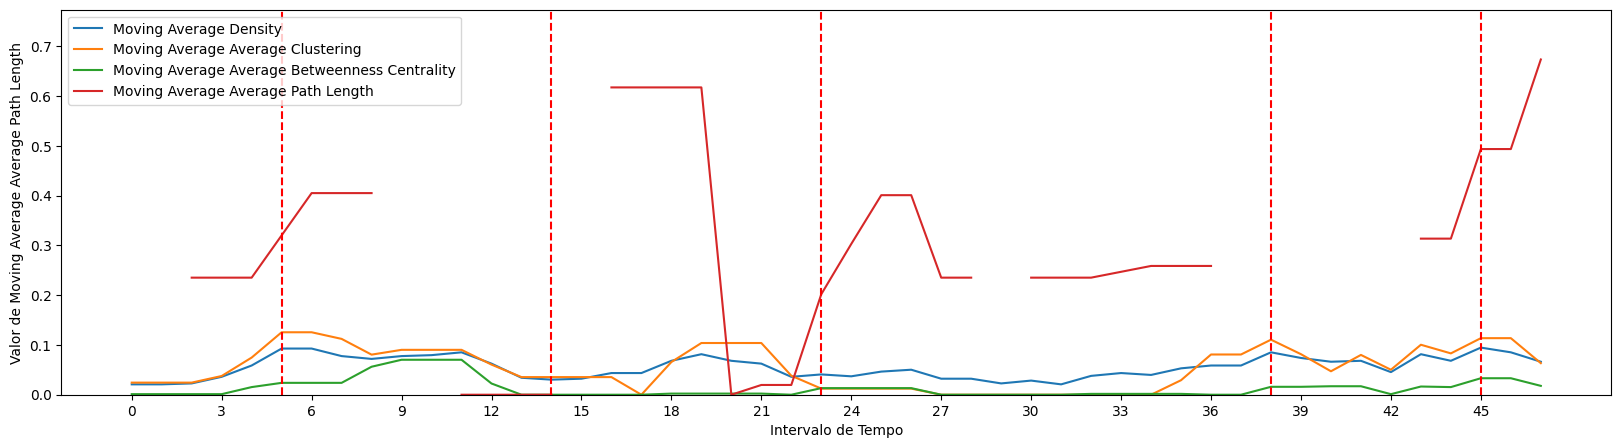

Team ID: 9


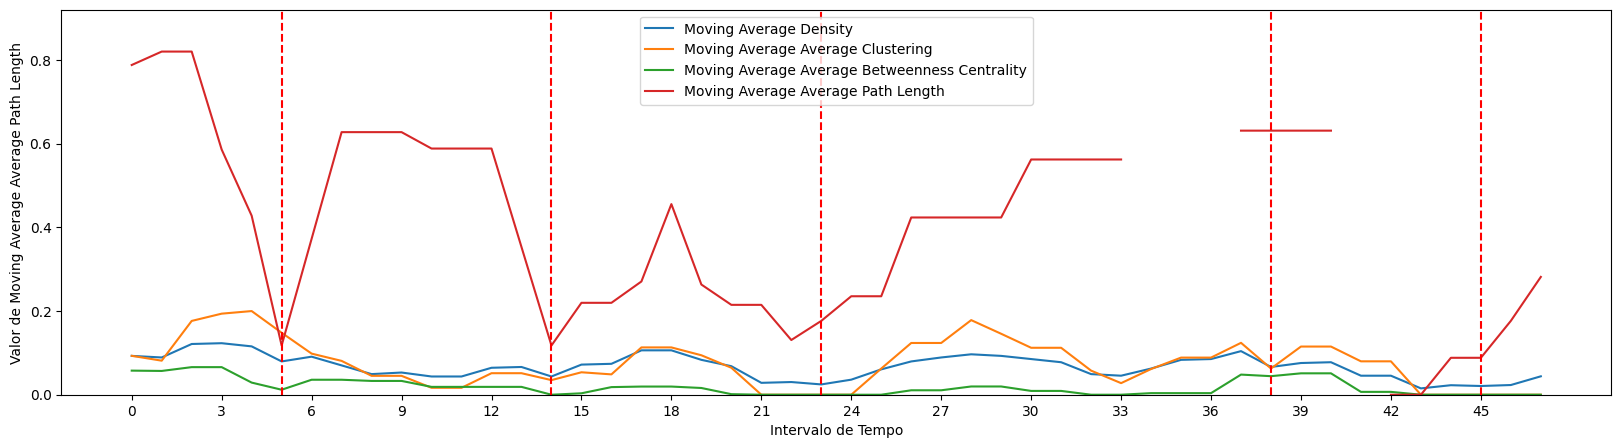

Match ID: 4579
Team ID: 1


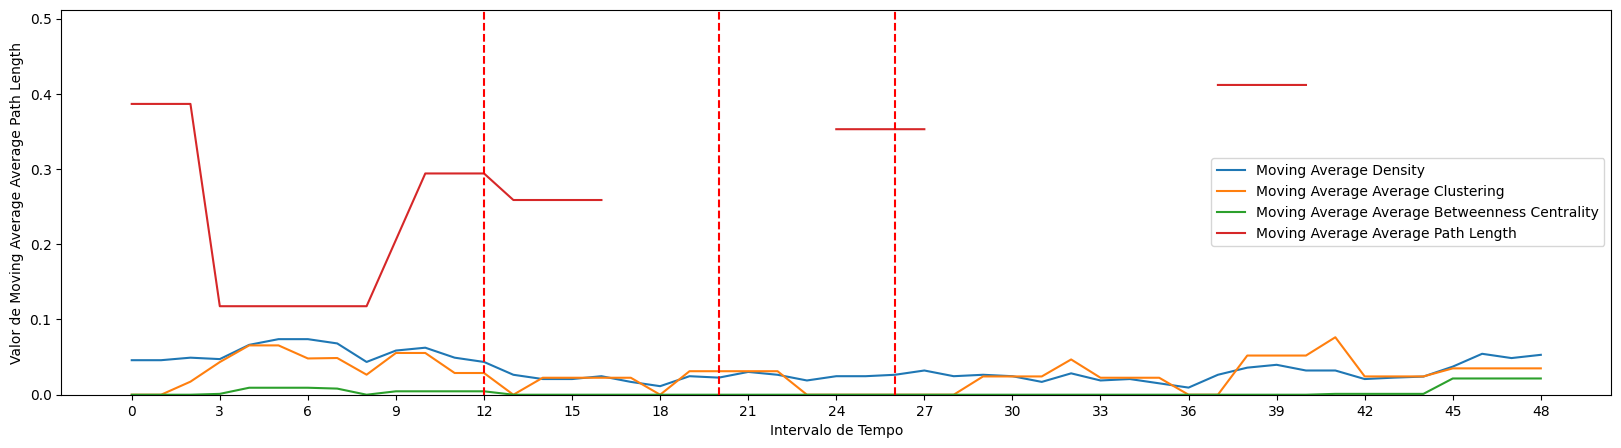

Team ID: 55


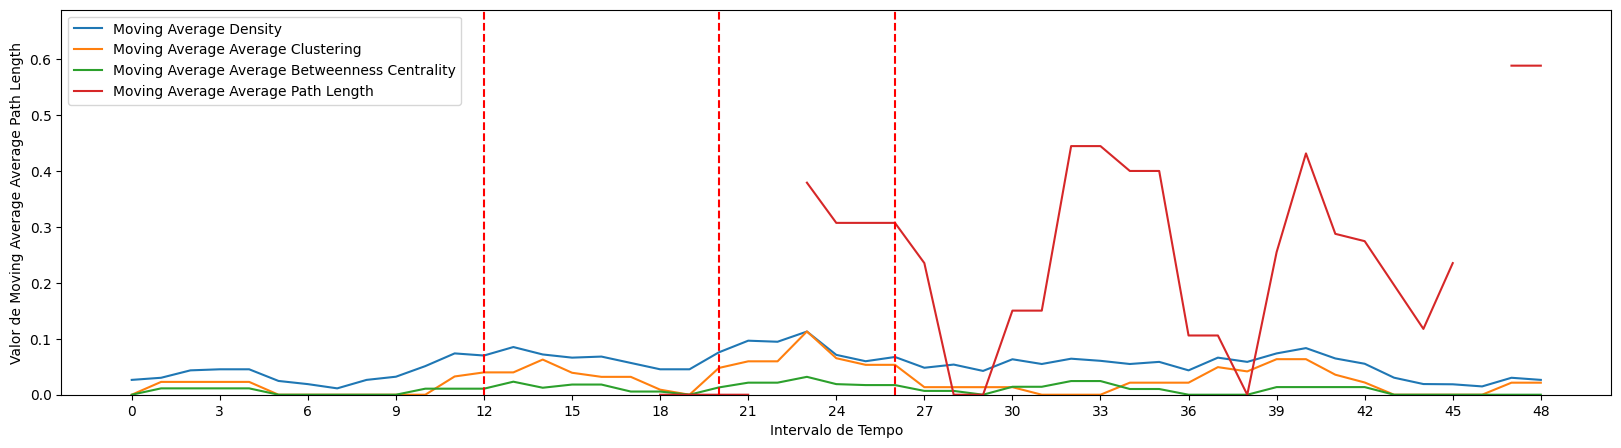

Match ID: 4583
Team ID: 10


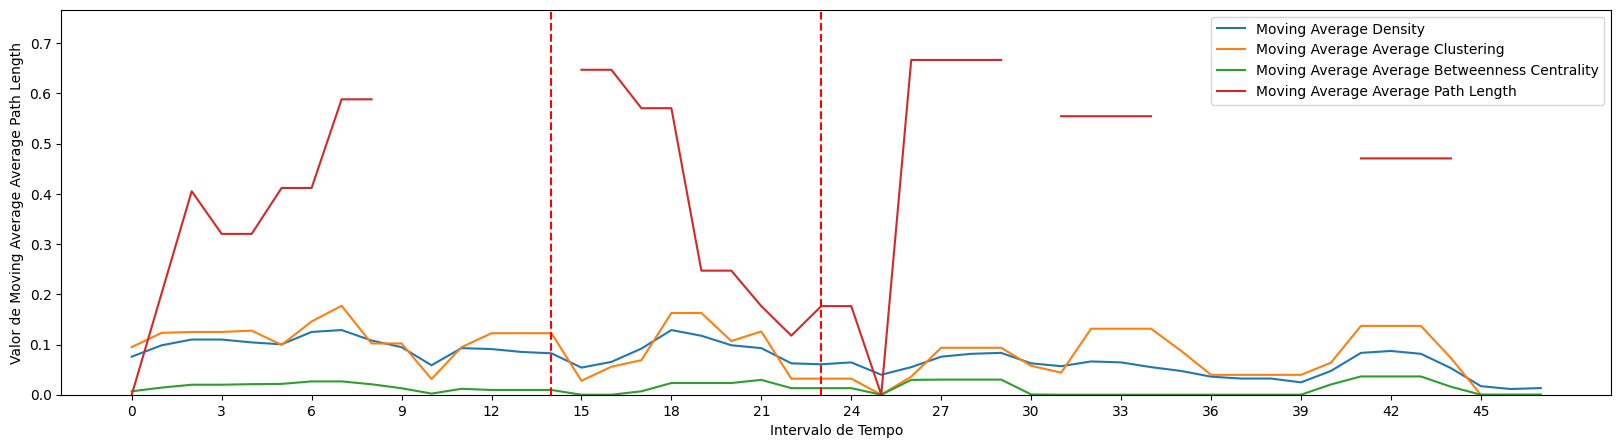

Team ID: 17


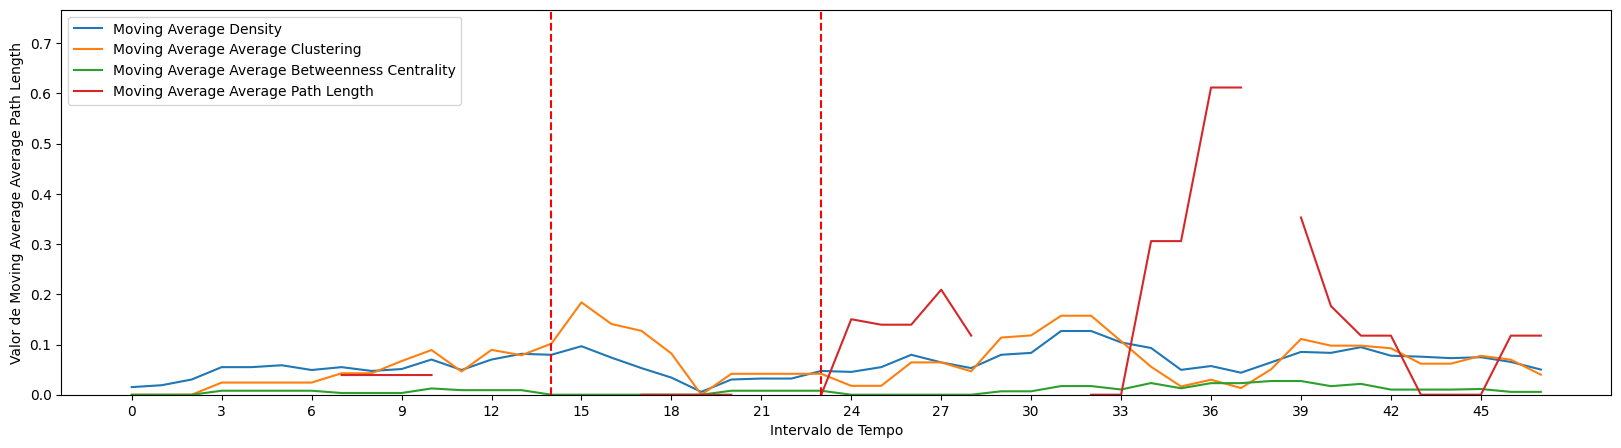

In [142]:
for match in drift_points[-45:-35]:
    match_id = match['match_id']
    if match_id in [4615, 4592, 4593, 4578, 4583, 4579]:
        print(f"Match ID: {match_id}")
            
        drift_pts = match['drift_points']

        df_match = df_sorted[df_sorted['match_id'] == match_id].reset_index(drop=True)

        # Selecionar a métrica desejada
        metrics = ['Density', 'Average Clustering', 'Average Betweenness Centrality', 'Average Path Length']

        teams_info_match = teams_info[teams_info['team_id'].isin(df_match['team_id'].unique())]
        team_names = teams_info_match['team_name'].tolist()

        plot_match_segmentation(
            df=df_match,
            drift_points=drift_pts,
            metrics=metrics,
            team_names=team_names,
            team_colors=['green', 'orange']
        )


In [ ]:
4615, 4592, 4593, 4578, 4583, 4579

# Team Characterization

In [28]:
team_interval_metrics = df_sorted.groupby(['team_id', 'interval_id']).agg({
    'Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()
team_interval_metrics.rename(columns={'Density': 'Average Density'}, inplace=True)
team_interval_metrics.head()

,team_id,interval_id,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
0,1,1.0,0.059809,0.045156,0.003748,0.067820,2.000000
1,1,2.0,0.031499,0.025909,0.004545,0.032722,3.222222
2,1,3.0,0.043798,0.024050,0.011962,0.049701,NaN
3,1,4.0,0.043737,0.045615,0.002153,0.050439,2.250000
4,1,5.0,0.047448,0.045154,0.010845,0.060506,1.539683


In [41]:
team_interval_metrics = team_interval_metrics.merge(teams_info, on='team_id', how='left')
team_interval_metrics.head()

,team_id,interval_id,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length,team_name,team_short_name,team_country,primary_color,secondary_color
0,1,1.0,0.059809,0.045156,0.003748,0.067820,2.000000,AFC Bournemouth,BOU,England,#E20613,#000000
1,1,2.0,0.031499,0.025909,0.004545,0.032722,3.222222,AFC Bournemouth,BOU,England,#E20613,#000000
2,1,3.0,0.043798,0.024050,0.011962,0.049701,NaN,AFC Bournemouth,BOU,England,#E20613,#000000
3,1,4.0,0.043737,0.045615,0.002153,0.050439,2.250000,AFC Bournemouth,BOU,England,#E20613,#000000
4,1,5.0,0.047448,0.045154,0.010845,0.060506,1.539683,AFC Bournemouth,BOU,England,#E20613,#000000


In [43]:
# Agrupar por 'team_id' e calcular a variância da 'Average Density' para cada time
variancia_densidade = team_interval_metrics.groupby('team_id')['Average Density'].var().reset_index()
# Renomear a coluna para melhor compreensão
variancia_densidade.rename(columns={'Average Density': 'Variancia Densidade'}, inplace=True)
# Ordenar os times pela variância em ordem decrescente
variancia_densidade = variancia_densidade.sort_values(by='Variancia Densidade', ascending=False)
# Exibir os times com maior variação na densidade média por intervalo
print(variancia_densidade)

    team_id  Variancia Densidade
4         6             0.000479
1         2             0.000429
8        10             0.000400
9        11             0.000315
13       17             0.000252
10       12             0.000211
3         4             0.000199
6         8             0.000192
16       54             0.000190
15       20             0.000188
5         7             0.000176
12       16             0.000147
17       55             0.000140
14       19             0.000138
0         1             0.000132
18      119             0.000131
7         9             0.000123
2         3             0.000122
11       13             0.000111
19      221             0.000093


C:\Users\jllgo\AppData\Local\Temp\ipykernel_28640\237516955.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Moving_Average_Density'] = df.groupby('team_id')['Average Density'].transform(lambda x: x.rolling(window=2, min_periods=1).mean())


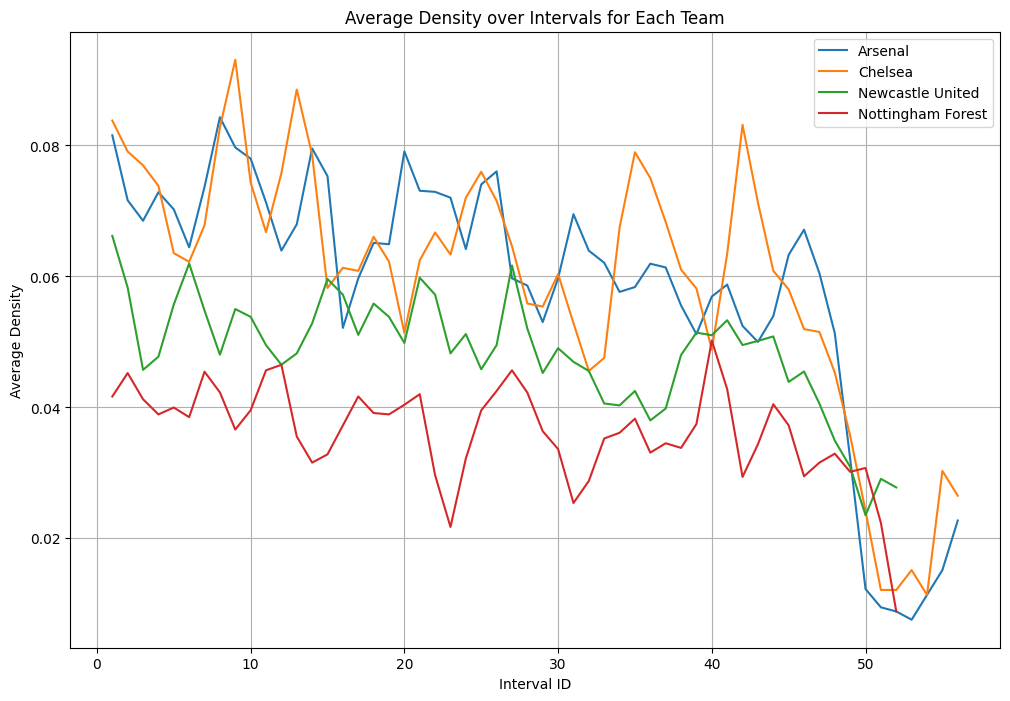

In [ ]:
plt.figure(figsize=(12, 8))

df = team_interval_metrics[team_interval_metrics['team_id'].isin([2])]

df['Moving_Average_Density'] = df.groupby('team_id')['Average Density'].transform(lambda x: x.rolling(window=2, min_periods=1).mean())

# Ordenar o DataFrame
df = df.sort_values(by=['team_id', 'interval_id'])

# Iterate over each team
for metric in df['team_name'].unique():
    team_data = df[df['team_name'] == team_name]
    plt.plot(team_data['interval_id'], team_data['Moving_Average_Density'], label=team_name)

plt.xlabel('Interval ID')
plt.ylabel('Average Density')
plt.title('Average Density over Intervals for Each Team')
plt.legend()
plt.grid(True)
plt.show()

In [113]:
metricas = ['Average Density', 'Average Clustering', 'Average Betweenness Centrality', 'Average Path Length']

# Calcular o desvio padrão das métricas por time e por partida
desvios_por_partida = df_grouped.groupby(['team_id', 'match_id'])[metricas].std().reset_index()

max_desvios = desvios_por_partida.groupby('team_id').max().reset_index()
max_desvios.merge(teams_info, on='team_id', how='left').sort_values(by='Average Density', ascending=False)

,team_id,match_id,Average Density,Average Clustering,Average Betweenness Centrality,Average Path Length,team_name,team_short_name,team_country,primary_color,secondary_color
1,2,4616,0.041379,0.062606,0.025875,0.870457,Arsenal,ARS,England,#E10B17,#FFFFFF
10,12,4624,0.040068,0.073368,0.014950,1.144165,Manchester United,MUN,England,#D91117,#221E20
7,9,4623,0.038597,0.063533,0.022127,1.277745,Leicester City,LCI,England,#233A80,#FFFFFF
2,3,4617,0.036810,0.062491,0.014913,1.205813,Aston Villa,AVL,England,#660E36,#93BDE4
9,11,4619,0.036809,0.048439,0.020376,1.146507,Manchester City,MCI,England,#6CABDD,#FFFFFF
4,6,4619,0.036435,0.080567,0.024953,1.240766,Chelsea,CHE,England,#184890,#1D1D1D
15,20,4617,0.035019,0.055685,0.014457,1.458333,Wolverhampton Wanderers,WLV,England,#F59E1F,#000000
8,10,4618,0.034492,0.069300,0.015071,1.163780,Liverpool,LIV,England,#D01317,#FFFFFF
17,55,4622,0.033500,0.043058,0.017833,1.108999,Leeds United,LEE,England,#FFFFFF,#1763A8
12,16,4625,0.030053,0.051368,0.013372,1.826693,Southampton,SOU,England,#D01317,#FFFFFF


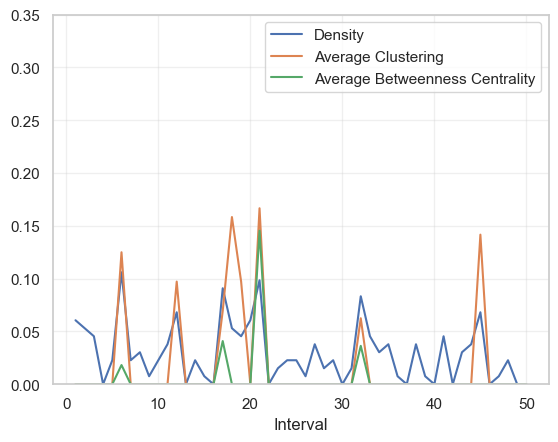

In [110]:
metricas = ['Density', 'Average Clustering', 'Average Betweenness Centrality']

for metric in metricas:
    team_data = df_sorted[(df_sorted['team_id'] == 221) & (df_sorted['match_id'] == 4625)]
    team_data = team_data.merge(teams_info, on='team_id', how='left')

    plt.plot(team_data['interval_id'], team_data[metric], label=metric)

plt.ylim(0, 0.35)
plt.xlabel('Interval')
#plt.title('Average Density over Intervals for Each Team')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

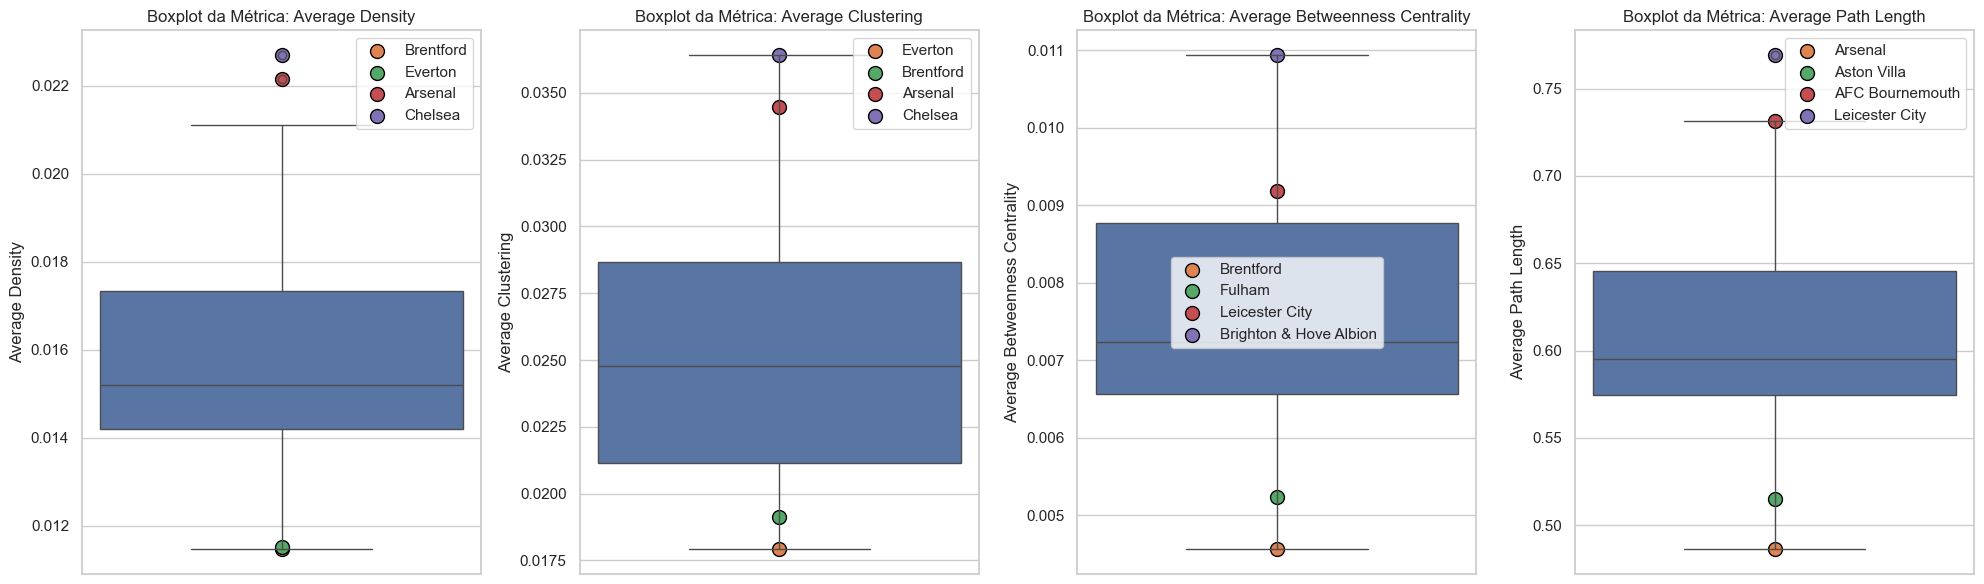

In [92]:
import seaborn as sns

metricas = ['Average Density', 'Average Clustering', 'Average Betweenness Centrality', 'Average Path Length']

# Calcular o desvio padrão das métricas por time e por partida
desvios_por_partida = df_grouped.groupby(['team_id', 'match_id'])[metricas].std().reset_index()

# Calcular a média dos desvios padrão para cada time ao longo de todas as partidas
media_desvios_por_time = desvios_por_partida.groupby('team_id')[metricas].mean().reset_index()

media_desvios_por_time = media_desvios_por_time.merge(teams_info, on='team_id', how='left')

fig, axes = plt.subplots(1, len(metricas), figsize=(20, 6), sharey=False)

handles_labels = {}

for ax, metrica in zip(axes, metricas):
    # Ordenar os times pelo desvio padrão da métrica
    ordenado = media_desvios_por_time.sort_values(by=metrica)
    
    # Selecionar os dois times com menor variação
    menor_variacao = ordenado.head(2)
    # Selecionar os dois times com maior variação
    maior_variacao = ordenado.tail(2)
    
    # Concatenar os resultados
    selecionados = pd.concat([menor_variacao, maior_variacao])
    
    # Criar o boxplot para a métrica
    sns.boxplot(y=metrica, data=media_desvios_por_time, ax=ax, showfliers=True)
    
    # Sobrepor os pontos dos times selecionados
    for _, row in selecionados.iterrows():
        team_data = media_desvios_por_time[media_desvios_por_time['team_id'] == row['team_id']]
        scatter = ax.scatter([0] * len(team_data), team_data[metrica], label=f'{row["team_name"]}', s=100, edgecolor='black')

        #handles_labels[f'{row["team_name"]}'] = scatter
    
    ax.legend()
    ax.set_title(f'Boxplot da Métrica: {metrica}')
    ax.set_xlabel('')
    ax.set_ylabel(metrica)

#fig.legend(handles_labels.values(), handles_labels.keys(), loc='upper right')
plt.tight_layout()
plt.show()


In [29]:
team_metrics_avg_per_interval = df_sorted.groupby('team_id').agg({
    'Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()
team_metrics_avg_per_interval.head()

,team_id,Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
0,1,0.041398,0.033084,0.006206,0.045075,1.570790
1,2,0.063403,0.065580,0.013361,0.095168,1.800568
2,3,0.050394,0.043359,0.009558,0.065203,1.694847
3,4,0.062584,0.062975,0.014369,0.090507,1.879920
4,6,0.063931,0.067282,0.013158,0.096137,1.838402


In [30]:

metric_columns = ['Density', 'Average Clustering', 'Average Betweenness Centrality',
                  'Average Closeness Centrality', 'Average Path Length']

# Aplicar a normalização Min-Max
team_metrics_normalized = team_metrics_avg_per_interval.copy()
team_metrics_normalized[metric_columns] = (team_metrics_avg_per_interval[metric_columns] - team_metrics_avg_per_interval[metric_columns].min()) / (team_metrics_avg_per_interval[metric_columns].max() - team_metrics_avg_per_interval[metric_columns].min())

team_metrics_normalized.sort_values(by='Density', ascending=False, inplace=True)

team_metrics_normalized = team_metrics_normalized.merge(teams_info[['team_id', 'team_name']], on='team_id', how='left')

team_metrics_normalized.head()

,team_id,Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length,team_name
0,11,1.000000,1.000000,1.000000,1.000000,1.000000,Manchester City
1,10,0.759036,0.669164,0.753279,0.728419,0.689445,Liverpool
2,6,0.615342,0.592680,0.642044,0.595917,0.707779,Chelsea
3,2,0.603224,0.566952,0.657398,0.586057,0.643012,Arsenal
4,4,0.584452,0.527578,0.733547,0.538621,0.778851,Brighton & Hove Albion


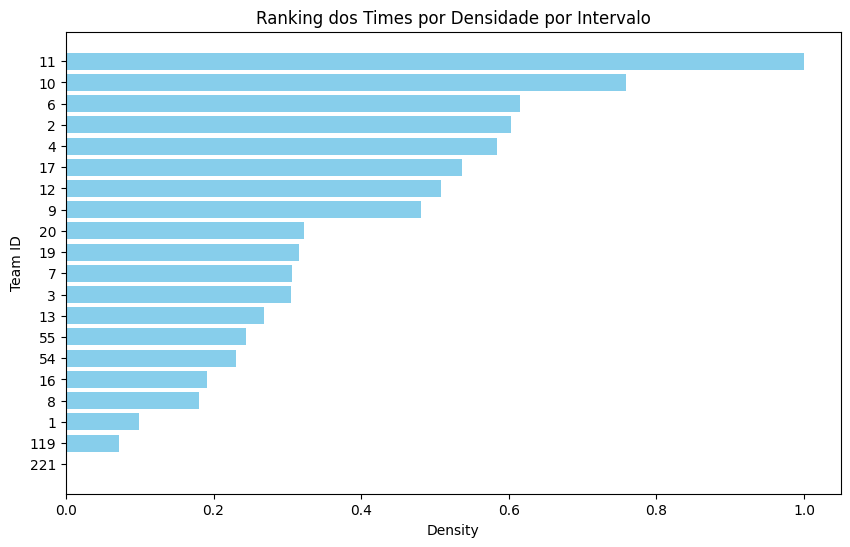

In [31]:
plt.figure(figsize=(10, 6))
plt.barh(team_metrics_normalized['team_id'].astype(str), team_metrics_normalized['Density'], color='skyblue')
plt.xlabel('Density')
plt.ylabel('Team ID')
plt.title(f'Ranking dos Times por Densidade por Intervalo')
plt.gca().invert_yaxis()  # Inverter o eixo y para que o primeiro colocado fique no topo
plt.show()

In [32]:
metricas = ['Density', 'Average Clustering', 'Average Betweenness Centrality', 'Average Closeness Centrality', 'Average Path Length']

# Calcular o ranking para cada métrica
for metrica in metricas:
    coluna_ranking = metrica + ' Rank'
    team_metrics_normalized[coluna_ranking] = team_metrics_normalized[metrica].rank(ascending=False, method='min')

team_metrics_normalized

,team_id,Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length,team_name,Density Rank,Average Clustering Rank,Average Betweenness Centrality Rank,Average Closeness Centrality Rank,Average Path Length Rank
0,11,1.000000,1.000000,1.000000,1.000000,1.000000,Manchester City,1.0,1.0,1.0,1.0,1.0
1,10,0.759036,0.669164,0.753279,0.728419,0.689445,Liverpool,2.0,2.0,2.0,2.0,6.0
2,6,0.615342,0.592680,0.642044,0.595917,0.707779,Chelsea,3.0,3.0,5.0,3.0,5.0
3,2,0.603224,0.566952,0.657398,0.586057,0.643012,Arsenal,4.0,4.0,4.0,4.0,7.0
4,4,0.584452,0.527578,0.733547,0.538621,0.778851,Brighton & Hove Albion,5.0,5.0,3.0,5.0,4.0
5,17,0.536379,0.439381,0.515176,0.504928,0.783781,Tottenham Hotspur,6.0,7.0,7.0,6.0,3.0
6,12,0.508747,0.481455,0.573193,0.462350,0.808556,Manchester United,7.0,6.0,6.0,7.0,2.0
7,9,0.481265,0.429357,0.395329,0.448482,0.610595,Leicester City,8.0,8.0,10.0,8.0,8.0
8,20,0.322889,0.256613,0.342678,0.296592,0.493745,Wolverhampton Wanderers,9.0,10.0,12.0,9.0,11.0
9,19,0.315646,0.283357,0.410157,0.287002,0.302735,West Ham,10.0,9.0,8.0,10.0,13.0


In [33]:
paper_rank = team_metrics_normalized[['team_name', 'Density Rank', 'Average Clustering Rank', 'Average Closeness Centrality Rank', 'Average Path Length Rank']]

paper_rank.loc[:,['Density Rank', 'Average Clustering Rank', 'Average Closeness Centrality Rank', 'Average Path Length Rank']] = paper_rank.loc[:,['Density Rank', 'Average Clustering Rank', 'Average Closeness Centrality Rank', 'Average Path Length Rank']].astype(int)

paper_rank

,team_name,Density Rank,Average Clustering Rank,Average Closeness Centrality Rank,Average Path Length Rank
0,Manchester City,1.0,1.0,1.0,1.0
1,Liverpool,2.0,2.0,2.0,6.0
2,Chelsea,3.0,3.0,3.0,5.0
3,Arsenal,4.0,4.0,4.0,7.0
4,Brighton & Hove Albion,5.0,5.0,5.0,4.0
5,Tottenham Hotspur,6.0,7.0,6.0,3.0
6,Manchester United,7.0,6.0,7.0,2.0
7,Leicester City,8.0,8.0,8.0,8.0
8,Wolverhampton Wanderers,9.0,10.0,9.0,11.0
9,West Ham,10.0,9.0,10.0,13.0


In [34]:
# Transform the columns of paper_rank to int (except team_name)
columns_to_transform = paper_rank.columns.difference(['team_name'])
paper_rank[columns_to_transform] = paper_rank[columns_to_transform].astype(int)

paper_rank

C:\Users\jllgo\AppData\Local\Temp\ipykernel_28640\1376702782.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paper_rank[columns_to_transform] = paper_rank[columns_to_transform].astype(int)


,team_name,Density Rank,Average Clustering Rank,Average Closeness Centrality Rank,Average Path Length Rank
0,Manchester City,1,1,1,1
1,Liverpool,2,2,2,6
2,Chelsea,3,3,3,5
3,Arsenal,4,4,4,7
4,Brighton & Hove Albion,5,5,5,4
5,Tottenham Hotspur,6,7,6,3
6,Manchester United,7,6,7,2
7,Leicester City,8,8,8,8
8,Wolverhampton Wanderers,9,10,9,11
9,West Ham,10,9,10,13


### Phase

In [35]:
df_grouped_phase = df_grouped[['team_id', 'Average Density','Average Clustering',	'Average Betweenness Centrality' ,'Average Closeness Centrality', 'Average Path Length']].groupby(['team_id']).agg({
    'Average Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()

metric_columns = ['Average Density', 'Average Clustering', 'Average Betweenness Centrality',
                  'Average Closeness Centrality', 'Average Path Length']

# Aplicar a normalização Min-Max
team_phase_metrics_normalized = df_grouped_phase.copy()
team_phase_metrics_normalized[metric_columns] = (team_phase_metrics_normalized[metric_columns] - team_phase_metrics_normalized[metric_columns].min()) / (team_phase_metrics_normalized[metric_columns].max() - team_phase_metrics_normalized[metric_columns].min())

team_phase_metrics_normalized.sort_values(by='Average Density', ascending=False, inplace=True)

team_phase_metrics_normalized = team_phase_metrics_normalized.merge(teams_info[['team_id', 'team_name']], on='team_id', how='left')

metricas = ['Average Density', 'Average Clustering', 'Average Betweenness Centrality', 'Average Closeness Centrality', 'Average Path Length']

# Calcular o ranking para cada métrica
for metrica in metricas:
    coluna_ranking = metrica + ' Rank'
    team_phase_metrics_normalized[coluna_ranking] = team_phase_metrics_normalized[metrica].rank(ascending=False, method='min')

team_phase_metrics_normalized

,team_id,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length,team_name,Average Density Rank,Average Clustering Rank,Average Betweenness Centrality Rank,Average Closeness Centrality Rank,Average Path Length Rank
0,11,1.000000,1.000000,1.000000,1.000000,1.000000,Manchester City,1.0,1.0,1.0,1.0,1.0
1,10,0.695659,0.658708,0.577243,0.655801,0.529471,Liverpool,2.0,2.0,4.0,2.0,10.0
2,4,0.599620,0.583828,0.718490,0.555399,0.821768,Brighton & Hove Albion,3.0,4.0,2.0,4.0,2.0
3,6,0.584825,0.609013,0.571701,0.565591,0.787904,Chelsea,4.0,3.0,5.0,3.0,3.0
4,2,0.547413,0.522066,0.592041,0.532281,0.553042,Arsenal,5.0,6.0,3.0,5.0,9.0
5,12,0.529771,0.522378,0.515561,0.457708,0.749691,Manchester United,6.0,5.0,6.0,6.0,4.0
6,17,0.493269,0.409972,0.419409,0.455409,0.671607,Tottenham Hotspur,7.0,7.0,7.0,7.0,5.0
7,9,0.411823,0.363276,0.390434,0.383322,0.658690,Leicester City,8.0,8.0,8.0,8.0,6.0
8,20,0.330474,0.270377,0.233641,0.289668,0.410966,Wolverhampton Wanderers,9.0,9.0,13.0,9.0,12.0
9,19,0.293008,0.267889,0.318150,0.258339,0.251370,West Ham,10.0,10.0,9.0,11.0,15.0


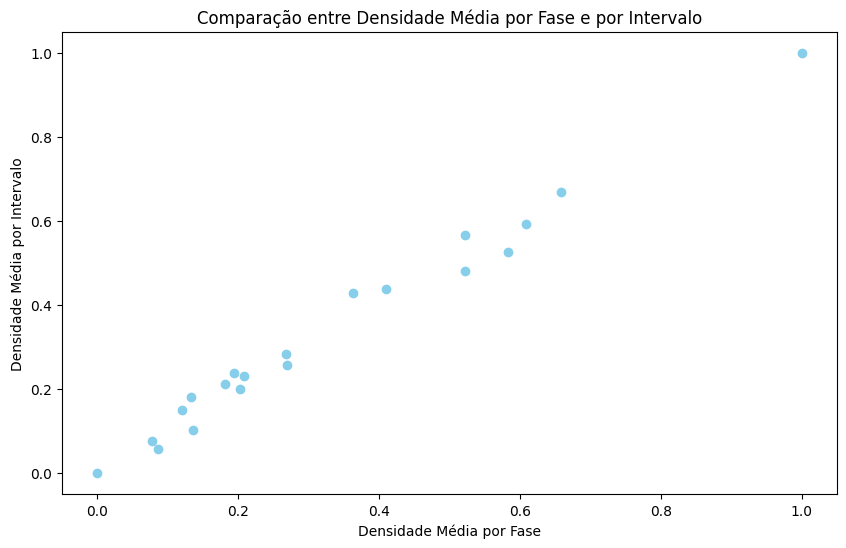

In [36]:
x = team_phase_metrics_normalized.sort_values('team_id').reset_index(drop=True)['Average Clustering']
y = team_metrics_normalized.sort_values('team_id').reset_index(drop=True)['Average Clustering']

plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='skyblue')
plt.xlabel('Densidade Média por Fase')
plt.ylabel('Densidade Média por Intervalo')
plt.title('Comparação entre Densidade Média por Fase e por Intervalo')
plt.show()

### Match

In [37]:
df_grouped_match = df_sorted[['match_id', 'team_id', 'Density', 'Average Clustering', 'Average Betweenness Centrality', 'Average Closeness Centrality', 'Average Path Length']].groupby(['match_id', 'team_id']).agg({
    'Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()
df_grouped_match.rename(columns={'Density': 'Average Density'}, inplace=True)
df_grouped_match.head()

,match_id,team_id,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
0,4436,2,0.052872,0.059360,0.012390,0.078677,1.616327
1,4436,7,0.065450,0.058929,0.018728,0.103282,2.061648
2,4438,1,0.032762,0.013812,0.001000,0.018745,0.916667
3,4438,3,0.069103,0.062291,0.010212,0.100693,2.082296
4,4439,20,0.067968,0.051216,0.013466,0.102174,1.660820


In [38]:
df_grouped_per_match = df_grouped_match[['team_id', 'Average Density','Average Clustering',	'Average Betweenness Centrality' ,'Average Closeness Centrality', 'Average Path Length']].groupby(['team_id']).agg({
    'Average Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()

metric_columns = ['Average Density', 'Average Clustering', 'Average Betweenness Centrality',
                  'Average Closeness Centrality', 'Average Path Length']

# Aplicar a normalização Min-Max
team_match_metrics_normalized = df_grouped_per_match.copy()
team_match_metrics_normalized[metric_columns] = (team_match_metrics_normalized[metric_columns] - team_match_metrics_normalized[metric_columns].min()) / (team_match_metrics_normalized[metric_columns].max() - team_match_metrics_normalized[metric_columns].min())

team_match_metrics_normalized.sort_values(by='Average Density', ascending=False, inplace=True)

team_match_metrics_normalized = team_match_metrics_normalized.merge(teams_info[['team_id', 'team_name']], on='team_id', how='left')

metricas = ['Average Density', 'Average Clustering', 'Average Betweenness Centrality', 'Average Closeness Centrality', 'Average Path Length']

# Calcular o ranking para cada métrica
for metrica in metricas:
    coluna_ranking = metrica + ' Rank'
    team_match_metrics_normalized[coluna_ranking] = team_match_metrics_normalized[metrica].rank(ascending=False, method='min')

team_match_metrics_normalized

,team_id,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length,team_name,Average Density Rank,Average Clustering Rank,Average Betweenness Centrality Rank,Average Closeness Centrality Rank,Average Path Length Rank
0,11,1.000000,1.000000,1.000000,1.000000,1.000000,Manchester City,1.0,1.0,1.0,1.0,1.0
1,10,0.758953,0.670166,0.750636,0.728308,0.711689,Liverpool,2.0,2.0,2.0,2.0,5.0
2,6,0.613513,0.589747,0.638528,0.594427,0.704830,Chelsea,3.0,3.0,5.0,3.0,6.0
3,2,0.604774,0.568301,0.655699,0.587574,0.666112,Arsenal,4.0,4.0,4.0,4.0,7.0
4,4,0.583614,0.525335,0.731056,0.538376,0.781505,Brighton & Hove Albion,5.0,5.0,3.0,5.0,3.0
5,17,0.535444,0.437652,0.511886,0.504130,0.734482,Tottenham Hotspur,6.0,7.0,7.0,6.0,4.0
6,12,0.506499,0.478346,0.571215,0.460735,0.874238,Manchester United,7.0,6.0,6.0,7.0,2.0
7,9,0.479097,0.427547,0.393243,0.446336,0.586968,Leicester City,8.0,8.0,10.0,8.0,8.0
8,20,0.327067,0.259879,0.343132,0.299836,0.424237,Wolverhampton Wanderers,9.0,10.0,12.0,9.0,12.0
9,19,0.316261,0.283289,0.409613,0.287256,0.276483,West Ham,10.0,9.0,8.0,10.0,13.0


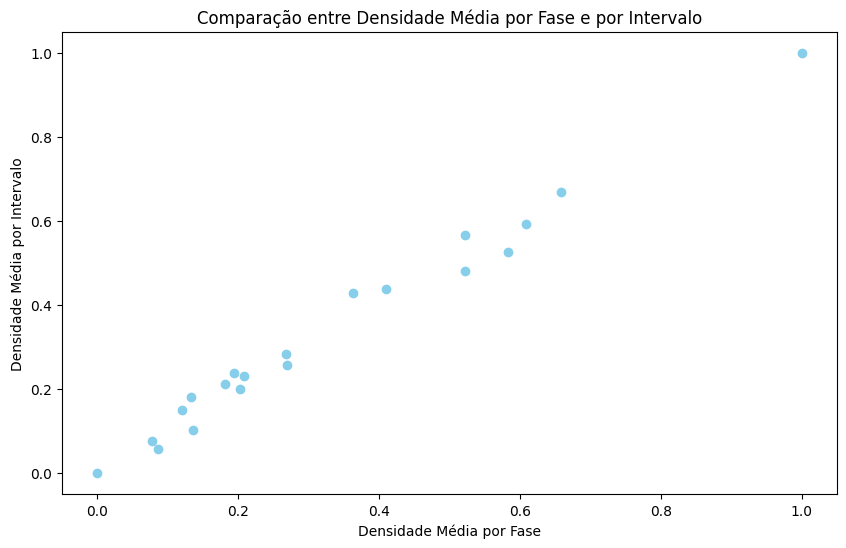

In [39]:
x = team_phase_metrics_normalized.sort_values('team_id').reset_index(drop=True)['Average Clustering']
y = team_metrics_normalized.sort_values('team_id').reset_index(drop=True)['Average Clustering']

plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='skyblue')
plt.xlabel('Densidade Média por Fase')
plt.ylabel('Densidade Média por Intervalo')
plt.title('Comparação entre Densidade Média por Fase e por Intervalo')
plt.show()

In [40]:
# Agrupar por 'phase_id' e 'team_id' e calcular a média dos valores
media_por_fase = df_sorted.groupby(['phase', 'team_id'])['Density'].mean().reset_index()

# 2. Agrupar por 'team_id' e calcular a média das médias de 'Density' por fase
media_das_medias_por_time = media_por_fase.groupby('team_id')['Density'].mean().reset_index()

# Renomear a coluna resultante para 'avg_density_per_phase'
media_das_medias_por_time = media_das_medias_por_time.rename(columns={'Density': 'avg_density_per_phase'})

# Exibir o resultado
print(media_das_medias_por_time)

    team_id  avg_density_per_phase
0         1               0.040389
1         2               0.055983
2         3               0.046978
3         4               0.063095
4         6               0.056254
5         7               0.041584
6         8               0.046930
7         9               0.051565
8        10               0.062261
9        11               0.068642
10       12               0.054834
11       13               0.050446
12       16               0.038582
13       17               0.057563
14       19               0.047649
15       20               0.044433
16       54               0.043151
17       55               0.045736
18      119               0.037746
19      221               0.032175
